# Refinando redes

### Carregando um modelo pré-treinado

In [1]:
import torch
from torch import nn
from torchvision.models import resnet18, ResNet18_Weights
import train

# Pesos treinados no dataset ImageNet
weights = ResNet18_Weights.DEFAULT
# Carrega o modelo com os pesos treinados. Esse código basicamente faz:
# 1. download(url_pesos) -> resnet18_imagenet.pt
# 2. model = resnet18()
# 3. model.load_state_dict('resnet18_imagenet.pt')
model = resnet18(weights=weights)
model.eval()

# Os pesos possuem informações sobre as categorias dos dados nos quais a rede foi treinada
categories = weights.meta["categories"]
print(categories)
print(len(categories))

['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'European fire salamander', 'common newt', 'eft', 'spotted salamander', 'axolotl', 'bullfrog', 'tree frog', 'tailed frog', 'loggerhead', 'leatherback turtle', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'common iguana', 'American chameleon', 'whiptail', 'agama', 'frilled lizard', 'alligator lizard', 'Gila monster', 'green lizard', 'African chameleon', 'Komodo dragon', 'African crocodile', 'American alligator', 'triceratops', 'thunder snake', 'ringneck snake', 'hognose snake', 'green snake', 'king snake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constrictor', 'rock python', 'Indian cobra', 'green mamba', 'sea snake', 'horned viper', 'diamondback', 

O objeto `weights` também possui as transformações que foram utilizadas nas imagens para a validação do modelo. Em geral, elas envolvem normalizar a intensidade e o tamanho da imagem. Pode ser útil utilizar as mesmas transformações em novos dados:

In [2]:
transforms = weights.transforms()
transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Segundo a [documentação](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html#torchvision.models.ResNet18_Weights), o pré-processamento é o seguinte:

1. A imagem é redimensionada para o tamanho 256x256
2. É feito um recorte no centro da imagem de tamanho 224x224
3. Os valores são transformados de [0,255] para [0.,1.]
4. Os valores são normalizados pela média [0.485, 0.456, 0.406] e desvio padrão [0.229, 0.224, 0.225]. Essas estatísticas são a média e desvio dos três canais de todas as imagens do ImageNet

### Estratégias de refinamento

Verifiquei que a acurácia do modelo no conjunto de validação é de 53%, ou seja, a classificação é aleatória. Vamos tentar refinar o modelo.

#### Refinar todo o modelo

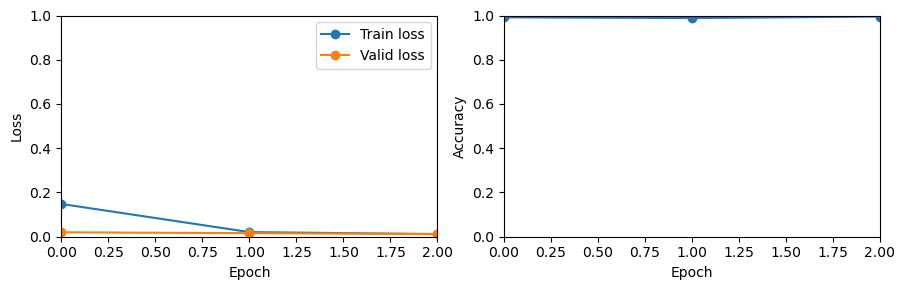

In [2]:
params = {
    'bs':256,
    'num_epochs':3,
    'lr':0.01,
    'weight_decay':1e-3,
    'resize_size':224,  
    'seed':0
}

model = resnet18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 2)
ds_train, ds_valid, logger = train.train(model, **params)
#1m25s

In [7]:
print('Acurácia:',100*logger[-1][3])

Acurácia: 98.63853454589844


Treinar por três épocas já resultou em uma performance muito boa! Isso porque os pesos carregados foram treiandos em imagens reais, incluindo imagens de cachorros e gatos. 

#### Refinar apenas a camada de classificação

Em muito casos podemos considerar que a rede está extraindo atributos relevantes das imagens, e precisamos apenas refinar a camada de classificação. Nesse caso, o treinamento da rede possui pouco custo, pois essencialmente estamos treinando uma regressão logística.

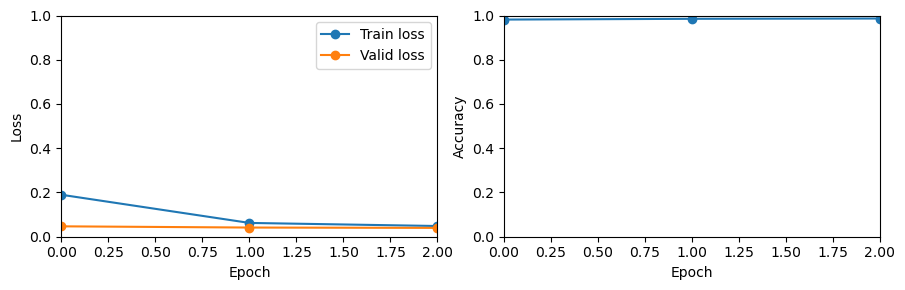

In [4]:
params = {
    'bs':256,
    'num_epochs':3,
    'lr':0.01,
    'weight_decay':1e-3,
    'resize_size':224,  
    'seed':0
}

model = resnet18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 2)
# Remove o cálculo de gradiente de todos os tensores da rede
model.requires_grad_(False)
# Ativa o cálculo de gradiente apenas da última camada
model.fc.requires_grad_(True)
ds_train, ds_valid, logger = train.train(model, **params)

In [8]:
print('Acurácia:',100*logger[-1][3])

Acurácia: 98.63853454589844


#### Refinar camadas da rede com diferentes taxas de aprendizado

É possível utilizar diferentes taxas de aprendizado para o modelo, basta fazer:

In [7]:
model

groups = [
    {'params':model.layer3.parameters(), 'lr':0.001},  # Estágio 3 terá lr=0.001
    {'params':model.layer4.parameters(), 'lr':0.001},  # Estágio 4 terá lr=0.001
    {'params':model.fc.parameters(), 'lr':0.01},       # Classificador terá lr=0.01
]
# Os parâmetros não especificados em `groups` não serão modificados pelo otimizador.
# O ideal é também remover o cálculo de gradientes desse parâmetros.
optim = torch.optim.SGD(groups)
